# 이미지 데이터 세트 구축

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import os, glob
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# 데이터 경로 설정
root_dir = "data/"

In [3]:
# 카테고리 지정 
categories = ["puppy", "cat", "dino", "rabbit", "fox"]
nb_classes = len(categories)

In [4]:
# 이미지 크기 지정
image_width = 64
image_height = 64

In [5]:
# 이미지 로딩
X = [] # 이미지 데이터
Y = [] # 레이블 데이터

for idx, category in enumerate(categories):
    image_dir = root_dir + category
    files = glob.glob(image_dir + "/" + "*.png")
    print(image_dir + "/" +"*.png")

    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_width, image_height))
        data = np.asarray(img)
        X.append(data)
        Y.append(idx)

X = np.array(X)
Y = np.array(Y)

data/puppy/*.png
data/cat/*.png
data/dino/*.png
data/rabbit/*.png
data/fox/*.png


In [6]:
# 학습 데이터와 테스트 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y)
xy = (x_train, x_test, y_train, y_test)
print("train.shape :", len(x_train))
print("test.shape :", len(x_test))

train.shape : 36
test.shape : 13


In [7]:
# 데이터 파일 저장
np.save(root_dir + "animal.npy", xy)

# 동물상 분류기 구축

In [8]:
# 데이터 로드
x_train, x_test, y_train, y_test = np.load("data/animal.npy", allow_pickle=True)
x_train = x_train.astype("float") / 256
x_test = x_test.astype("float") / 256
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)


In [9]:
# 모델 구축
model = Sequential([
                    Conv2D(32, (3,3), activation = 'relu', input_shape=x_train.shape[1:]),
                    MaxPooling2D(2,2),
                    Dropout(0.5),
                    Conv2D(64,(3,3), activation = 'relu'),
                    MaxPooling2D(2,2),
                    Dropout(0.5),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dropout(0.5),
                    Dense(nb_classes, activation = 'softmax')
                    ])

# VGG16 모델 구축(2-1)
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
transfer_model.trainable=False
model = Sequential([
                    transfer_model,
                    Flatten(),
                    Dropout(0.5),
                    Dense(512, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(5, activation='softmax'),
])

In [10]:
# 모델 컴파일
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [11]:
# 체크포인트 설정
checkpoint_path = "my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=0)

In [12]:
# 모델 학습
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=32,
                    epochs=50,
                    verbose=0,
                    callbacks=[checkpoint])

1/1 [==============================] - 0s 16ms/step - loss: 0.4387 - acc: 0.6154


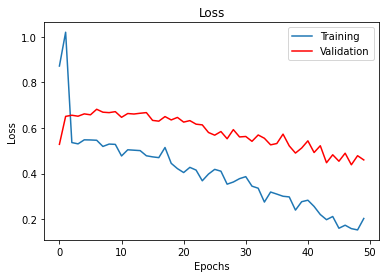

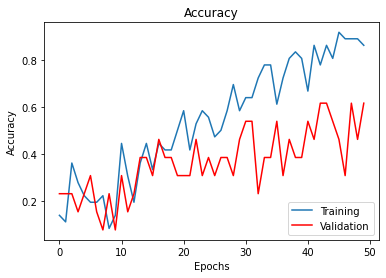

In [13]:
# 모델 평가
model.load_weights(checkpoint_path)
model.evaluate(x_test, y_test)

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(loss)
plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)

In [14]:
# 모델 저장
model.save("model/animal_model.h5")

# 모델 테스트

- 남성 유저들의 이미지를 활용하여 동물상을 분류

In [15]:
# 테스트 데이터 전처리
df = pd.read_csv('data/member_mate_sample.csv')
df1 = df.copy()

df = df[['mem_no','rprsn_photo','mem_sex']]
df.dropna(inplace=True)
df['rprsn_photo'] = df['rprsn_photo'].str[:-9].str.replace('|','')

path = 'data/image/'
files = os.listdir(path)

data2 = pd.DataFrame()
data2['a'] = files

data2['mem_no'] = data2['a'].str.split('_').str[0]
data2['mem_no'] = data2['mem_no'].astype('int64')

data3 = pd.merge(data2, df1[['mem_no','mem_sex']])

m_image = data3[data3['mem_sex'] == 'm']
m_image.reset_index(inplace=True, drop=True)

root_dir = "data/image/"

In [23]:
# 테스트 데이터 구축
image_files = []

for i in range(len(m_image)):
    image_files.append(root_dir + m_image['a'][i])
    
image_size = 64
categories = ["puppy", "cat", "dino", "rabbit", "fox"]
nb_classes = len(categories)

In [24]:
X = []
files = []
for fname in image_files:
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((image_size, image_size))
    in_data = np.asarray(img)
    in_data = in_data.astype("float") / 256
    X.append(in_data)
    files.append(fname)

X = np.array(X)

In [25]:
# 모댈 불러오기
model = load_model('model/animal_model.h5')

In [26]:
# 예측
pred = model.predict(X)

In [27]:
# 예측 데이터셋 생성
animal_list = []

for i in range(len(pred)):
    animal_list.append(categories[pred[i].argmax()])
    
m_image['animal'] = animal_list
m_image = m_image[['mem_no','animal']]

In [39]:
# to_csv
m_image.to_csv('data/animal.csv', index=False)